In [1]:
## Importing Libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Dropout, Activation, Conv3DTranspose
from tensorflow.keras.layers import BatchNormalization, GroupNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
import albumentations as A
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
import matplotlib.pyplot as plt
import os
from keras import backend as K
import segmentation_models_3D as sm

2024-07-26 09:58:20.586979: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-26 09:58:20.596496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 09:58:20.609776: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 09:58:20.609804: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 09:58:20.616933: I tensorflow/core/platform/cpu_feature_gua

Segmentation Models: using `keras` framework.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.16.2


#Parâmetros

In [3]:
augmentData = True
percent_train = 0.7
left = False
loadedresnet = False
n_epochs = 200
percent = int(percent_train * 100)
use_batch_norm = False
use_group_norm = True

In [4]:
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-07-26 09:58:22.245276: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-26 09:58:22.263579: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-26 09:58:22.263657: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
2024-07-26 09:58:22.267871: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without N

True

In [5]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [6]:
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [7]:
# Data Augmentation
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
    A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
    A.GridDistortion(p=0.5),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
     A.OpticalDistortion(),
])

# Função para aplicar aumento de dados
def apply_augmentation(image, mask):
    augmented = augmentation(image=image, mask=mask)
    return augmented['image'], augmented['mask']

In [8]:
from mpl_toolkits import mplot3d
from matplotlib import pyplot
import os

path_steel_stl= '../steel/stl'
paths = [os.path.join(path_steel_stl, folder) for folder in os.listdir(path_steel_stl)]
folders = [folder for folder in paths if os.path.isdir(folder)]

for folder in folders[:-3]:
    print(folder)
amostra= '03_09'
folder = os.path.join(path_steel_stl, amostra)
print(folder)

../steel/stl/03_09
../steel/stl/04_09
../steel/stl/06_06
../steel/stl/07_06
../steel/stl/07_09
../steel/stl/09_06
../steel/stl/11_06
../steel/stl/22_08
../steel/stl/03_09


In [9]:
def readImages(folder, n_patch = 64, step = 64):
    file_combined = os.path.join(folder,'output_combined_matriz_fibras.tif')
    file_fibras = os.path.join(folder,'output_fibras.tif')

    image = io.imread(file_combined)
    mask = io.imread(file_fibras)
    image_patches = patchify(image, (n_patch, n_patch, n_patch), step=step)
    mask_patches = patchify(mask, (n_patch, n_patch, n_patch), step=step)
    return image_patches, mask_patches



In [10]:
def augment_test_data(image_patches, mask_patches, train_images, train_masks):
    for i in range(image_patches.shape[0]):
        for j in range(image_patches.shape[1]):
            for k in range(image_patches.shape[2]):
                img_patch = image_patches[i, j, k, :, :, :]
                mask_patch = mask_patches[i, j, k, :, :, :]
                train_images.append(img_patch)
                train_masks.append(mask_patch)
                img_aug, mask_aug = apply_augmentation(img_patch, mask_patch)
                train_images.append(img_aug)
                train_masks.append(mask_aug)

In [11]:
def createTrain(folders, augmentData = True, percent_train=0.7, left =True):
    train_images = []
    train_masks = []
    num_pastas_selecionadas = int(len(folders) * percent_train)
    if left:
        selected_folders = folders[:num_pastas_selecionadas]
    else:
        num_pastas_selecionadas = len(folders) - num_pastas_selecionadas
        selected_folders = folders[num_pastas_selecionadas:]
    for folder in selected_folders:
        image_patches, mask_patches = readImages(folder)
        if augmentData:
            augment_test_data(image_patches, mask_patches, train_images, train_masks)
        else:
            for i in range(image_patches.shape[0]):
                for j in range(image_patches.shape[1]):
                    for k in range(image_patches.shape[2]):
                        img_patch = image_patches[i, j, k, :, :, :]
                        mask_patch = mask_patches[i, j, k, :, :, :]
                        train_images.append(img_patch)
                        train_masks.append(mask_patch)
    train_images = np.array(train_images)
    train_masks = np.array(train_masks)
    train_images = train_images.astype(np.uint8)
    train_masks = train_images.astype(np.uint8)
    for folder in selected_folders:
        print("Pastas treinadas " + folder)
    return train_images, train_masks

In [12]:
def preprocess(images, masks):
    images = np.stack((images,)*3, axis=-1)
    masks = np.expand_dims(masks, axis=4)
    images = images / 255.0
    masks = masks / 255.0
    return images, masks

In [13]:


train_images, train_masks = createTrain(folders, augmentData, percent_train, left)
print(train_images.shape)
print(train_masks.shape)


Pastas treinadas ../steel/stl/07_09
Pastas treinadas ../steel/stl/09_06
Pastas treinadas ../steel/stl/11_06
Pastas treinadas ../steel/stl/22_08
Pastas treinadas ../steel/stl/23_08
Pastas treinadas ../steel/stl/28_08
Pastas treinadas ../steel/stl/29_08
(896, 64, 64, 64)
(896, 64, 64, 64)


In [14]:
train_images, train_masks = preprocess(train_images, train_masks)
print(train_images.shape)
print(train_masks.shape)

(896, 64, 64, 64, 3)
(896, 64, 64, 64, 1)


In [15]:
import gc
gc.collect()

235

In [16]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

In [17]:
train_images.shape

(896, 64, 64, 64, 3)

In [18]:
X_train.shape

(716, 64, 64, 64, 3)

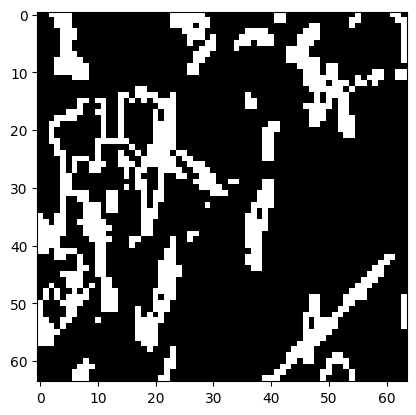

In [19]:
# Função para visualizar slices de volumes 3D
def show_slice(volume, slice_index):
    plt.imshow(volume[:, :, slice_index], cmap='gray')
    plt.show()

# Verificação de aumento de dados
sample_volume = X_train[0]

show_slice(sample_volume, 32)
del sample_volume

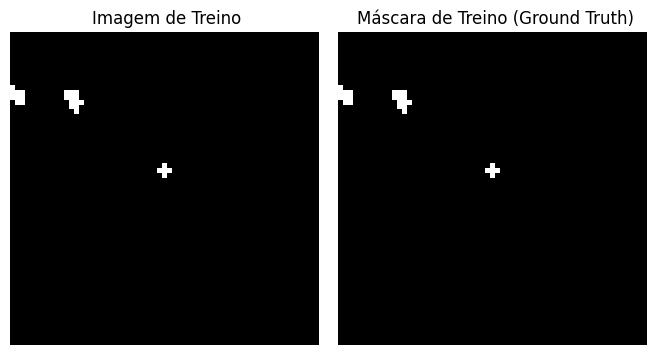

In [20]:
# Escolha um índice do slice que deseja visualizar (por exemplo, o meio)
slice_index = 32
imagem_treino = X_train[32]
mascara_treino = y_train[32]


# Plotar o slice escolhido
plt.figure(figsize=(10, 5))

# Original (Imagem de Teste)
plt.subplot(1, 3, 1)
plt.imshow(imagem_treino[ :, :, slice_index], cmap='gray')
plt.title('Imagem de Treino')
plt.axis('off')

# Ground Truth (Máscara de Teste)
plt.subplot(1, 3, 2)
plt.imshow(mascara_treino[:, :, slice_index], cmap='gray')
plt.title('Máscara de Treino (Ground Truth)')
plt.axis('off')

# # Predição (Resultado da Predição)
# plt.subplot(1, 3, 3)
# plt.imshow(reconstructed_image[slice_index, :, :], cmap='gray')
# plt.title('Resultado da Predição')
# plt.axis('off')

plt.tight_layout()
plt.show()

del imagem_treino
del mascara_treino

In [21]:
# Model Definition
def unet_model_3d(input_shape, num_classes=1, use_batch_norm=False, use_group_norm=False, groups=32):
    
    inputs = Input(input_shape)
    

    def conv_block(x, filters, use_batch_norm, use_group_norm):
        x = Conv3D(filters, (3, 3, 3), padding='same')(x)
        if use_batch_norm:
            x = BatchNormalization()(x)
        elif use_group_norm:
            x = GroupNormalization(groups=groups)(x)
        x = Activation('relu')(x)
        x = Conv3D(filters, (3, 3, 3), padding='same')(x)
        if use_batch_norm:
            x = BatchNormalization()(x)
        elif use_group_norm:
            x = GroupNormalization(groups=groups)(x)
        x = Activation('relu')(x)
        return x

    def encoder_block(x, filters, use_batch_norm, use_group_norm):
        x = conv_block(x, filters, use_batch_norm, use_group_norm)
        p = MaxPooling3D((2, 2, 2))(x)
        return x, p

    def decoder_block(x, conv_output, filters, use_batch_norm, use_group_norm):
        x = Conv3DTranspose(filters, (2, 2, 2), strides=(2, 2, 2), padding='same')(x)
        x = concatenate([x, conv_output])
        x = conv_block(x, filters, use_batch_norm, use_group_norm)
        return x

    filters = [32, 64, 128, 256, 512]

    # Encoder
    c1, p1 = encoder_block(inputs, filters[0], use_batch_norm, use_group_norm)
    c2, p2 = encoder_block(p1, filters[1], use_batch_norm, use_group_norm)
    c3, p3 = encoder_block(p2, filters[2], use_batch_norm, use_group_norm)
    c4, p4 = encoder_block(p3, filters[3], use_batch_norm, use_group_norm)

    # Bridge
    b = conv_block(p4, filters[4], use_batch_norm, use_group_norm)

    # Decoder
    d4 = decoder_block(b, c4, filters[3], use_batch_norm, use_group_norm)
    d3 = decoder_block(d4, c3, filters[2], use_batch_norm, use_group_norm)
    d2 = decoder_block(d3, c2, filters[1], use_batch_norm, use_group_norm)
    d1 = decoder_block(d2, c1, filters[0], use_batch_norm, use_group_norm)
    
    if num_classes == 1:
        outputs = Conv3D(1, (1, 1, 1), activation='sigmoid', dtype='float32')(d1)
    else:
        outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax', dtype='float32')(d1)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [22]:
# Definir a política de precisão mista
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)


# Model Training
input_shape = (64, 64, 64, 3)

model = unet_model_3d(input_shape, use_batch_norm=use_batch_norm, use_group_norm=use_group_norm)
model.summary()

2024-07-26 09:58:37.428135: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-26 09:58:37.430233: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-26 09:58:37.430262: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-26 09:58:37.434604: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-26 09:58:37.434616: I tensorflow/core/common_runtime/gpu/gpu

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 64, 64,    │      2,624 │ input_layer[0][0] │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalization │ (None, 64, 64,    │         64 │ conv3d[0][0]      │
│ (GroupNormalizatio… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ group_normalizat… │
│ (Activation)        │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 64, 64,    │     27,680 │ activation[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 64, 64,    │         64 │ conv3d_1[0][0]    │
│ (GroupNormalizatio… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ group_normalizat… │
│ (Activation)        │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 32, 32,    │          0 │ activation_1[0][… │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 32, 32,    │     55,360 │ max_pooling3d[0]… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 32, 32,    │        128 │ conv3d_2[0][0]    │
│ (GroupNormalizatio… │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ group_normalizat… │
│ (Activation)        │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 32, 32,    │    110,656 │ activation_2[0][… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 32, 32,    │        128 │ conv3d_3[0][0]    │
│ (GroupNormalizatio… │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ group_normalizat… │
│ (Activation)        │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 16, 16,    │          0 │ activation_3[0][… │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 16, 16,    │    221,312 │ max_pooling3d_1[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 16, 16,    │        256 │ conv3d_4[0][0]  

 Total params: 22,582,945 (86.15 MB)

 Trainable params: 22,582,945 (86.15 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from tensorflow.keras.applications import ResNet50

# Carregar o modelo ResNet50 pré-treinado na ImageNet
resnet = ResNet50(weights='imagenet', include_top=False)
resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [24]:
def convert_2d_to_3d(weights_2d):
    weights_3d = []
    for w in weights_2d:
        if w.ndim == 4:
            # Expandir a dimensão para 3D
            w3d = np.expand_dims(w, axis=2)
            w3d = np.tile(w3d, (1, 1, 3, 1, 1))  # Ajustar para (3, 3, 3, c_in, c_out)
            weights_3d.append(w3d)
        else:
            weights_3d.append(w)
    return weights_3d

In [25]:
# for i, layer in enumerate(resnet.layers):
#     print(i, layer.name)

In [26]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_layer
1 conv3d
2 group_normalization
3 activation
4 conv3d_1
5 group_normalization_1
6 activation_1
7 max_pooling3d
8 conv3d_2
9 group_normalization_2
10 activation_2
11 conv3d_3
12 group_normalization_3
13 activation_3
14 max_pooling3d_1
15 conv3d_4
16 group_normalization_4
17 activation_4
18 conv3d_5
19 group_normalization_5
20 activation_5
21 max_pooling3d_2
22 conv3d_6
23 group_normalization_6
24 activation_6
25 conv3d_7
26 group_normalization_7
27 activation_7
28 max_pooling3d_3
29 conv3d_8
30 group_normalization_8
31 activation_8
32 conv3d_9
33 group_normalization_9
34 activation_9
35 conv3d_transpose
36 concatenate
37 conv3d_10
38 group_normalization_10
39 activation_10
40 conv3d_11
41 group_normalization_11
42 activation_11
43 conv3d_transpose_1
44 concatenate_1
45 conv3d_12
46 group_normalization_12
47 activation_12
48 conv3d_13
49 group_normalization_13
50 activation_13
51 conv3d_transpose_2
52 concatenate_2
53 conv3d_14
54 group_normalization_14
55 activation_14
56 c

In [27]:
# Transferir pesos
def load_imagenet_weights(model, resnet, trainable = False):

    # Transferir os pesos da ResNet pré-treinada para a U-Net 3D
    for i in range(len(resnet.layers)):
        if isinstance(resnet.layers[i], tf.keras.layers.Conv3D):
            model.layers[i].set_weights(resnet.layers[i].get_weights())
            print(f"Transferred weights for layer {model.layers[i].name}")

    # Freezing the weights of the ResNet layers
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv3D):
            layer.trainable = trainable

# Transferir os pesos da ResNet pré-treinada para o modelo 3D U-Net
if loadedresnet:
    load_imagenet_weights(model, resnet, True)

In [28]:
import gc
del resnet
gc.collect()

17783

In [29]:
def data_generator(X, y, batch_size):
    dataset_size = X.shape[0]
    while True:
        indices = np.random.choice(dataset_size, batch_size, replace=False)
        batch_x = X[indices]
        batch_y = y[indices]
        yield batch_x, batch_y


def create_dataset(generator, output_shapes, output_types):
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=output_shapes[0], dtype=output_types[0]),
            tf.TensorSpec(shape=output_shapes[1], dtype=output_types[1])
        )
    )
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [30]:
batch_size = 1
train_generator = data_generator(X_train, y_train, batch_size)
val_generator = data_generator(X_val, y_val, batch_size)

output_shapes = [(batch_size, 64, 64, 64, 3), (batch_size, 64, 64, 64, 1)]
output_types = [tf.float32, tf.float32]

In [31]:
train_dataset = create_dataset(lambda: train_generator, output_shapes, output_types)
val_dataset = create_dataset(lambda: val_generator, output_shapes, output_types)

In [32]:
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

In [33]:
import random
test_img_number = random.randint(0, len(X_train))
test_img = X_train[test_img_number]
ground_truth=y_train[test_img_number]

del X_train
del X_val
del y_train
del y_val
gc.collect()

0

In [34]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


# Define configuration parameters
initial_learning_rate = 0.00001
min_lr = 0.000001
max_lr = 0.001
rampup_epochs = 10
sustain_epochs = 0
exp_decay = 0.8

# Define the scheduling function
def schedule(epoch):
  def lr(epoch, initial_learning_rate, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
    if epoch < rampup_epochs:
      lr = (max_lr - initial_learning_rate)/rampup_epochs * epoch + initial_learning_rate
    elif epoch < rampup_epochs + sustain_epochs:
      lr = max_lr
    else:
      lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    return lr
  return lr(epoch, initial_learning_rate, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
optimizer = Adam(learning_rate=initial_learning_rate)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: schedule(epoch), verbose=True)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', sm.metrics.IOUScore()])

In [35]:
import keras; print(keras.__version__)

3.3.3


In [36]:
# Callbacks
from datetime import datetime



folder_trained_models = 'trained_models/'
namemodel = f'model_loadedresnet_{loadedresnet}_percent{percent}_left{left}_aug_{augmentData}_{n_epochs}epochs_BN_{use_batch_norm}_GN_{use_group_norm}_{datetime.now():%Y-%m-%d %H-%m-%d}'
namefile = folder_trained_models + namemodel + '.keras'

checkpoint = ModelCheckpoint(namefile, monitor='val_iou_score', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_iou_score', patience=50, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_iou_score', factor=0.2, patience=10, min_lr=1e-6)

# callbacks = [checkpoint, early_stopping, reduce_lr, lr_callback]
callbacks = [checkpoint, reduce_lr, lr_callback]

# Clear session to avoid memory overflow
tf.keras.backend.clear_session()


In [37]:
# Training
import time
start_time = time.time()
history = model.fit(train_dataset,
                    epochs=n_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/200


I0000 00:00:1721998726.791133 3026182 service.cc:145] XLA service 0x7fa308003d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721998726.791767 3026182 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-07-26 09:58:46.938511: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-26 09:58:47.834295: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1721998738.983445 3026182 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


716/716 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.8101 - iou_score: 0.2346 - loss: 0.3575 - val_accuracy: 0.8558 - val_iou_score: 0.3701 - val_loss: 0.2060 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 0.00010899999999999999.
Epoch 2/200
716/716 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.8551 - iou_score: 0.4330 - loss: 0.1600 - val_accuracy: 0.8881 - val_iou_score: 0.5854 - val_loss: 0.0946 - learning_rate: 1.0900e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000208.
Epoch 3/200
716/716 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.8793 - iou_score: 0.5752 - loss: 0.0893 - val_accuracy: 0.8676 - val_iou_score: 0.6507 - val_loss: 0.0765 - learning_rate: 2.0800e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000307.
Epoch 4/200
716/716 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.8757 - iou_score: 0.6690 - loss: 0.0712 - val_accuracy: 0.8928 - val_iou_score: 0.7306 - val_loss: 0.0652 - learning_ra

In [38]:
end_time = time.time()
def format_time(seconds):
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours:.0f} horas, {minutes:.0f} minutos e {seconds:.2f} segundos"

elapsed_time = end_time - start_time
formatted_time = format_time(elapsed_time)
print(f"Tempo total: {formatted_time}")

 


Tempo total: 1 horas, 38 minutos e 57.47 segundos


In [39]:
import pickle
namehistoryDict = namemodel + '.pkl'
with open(namehistoryDict, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

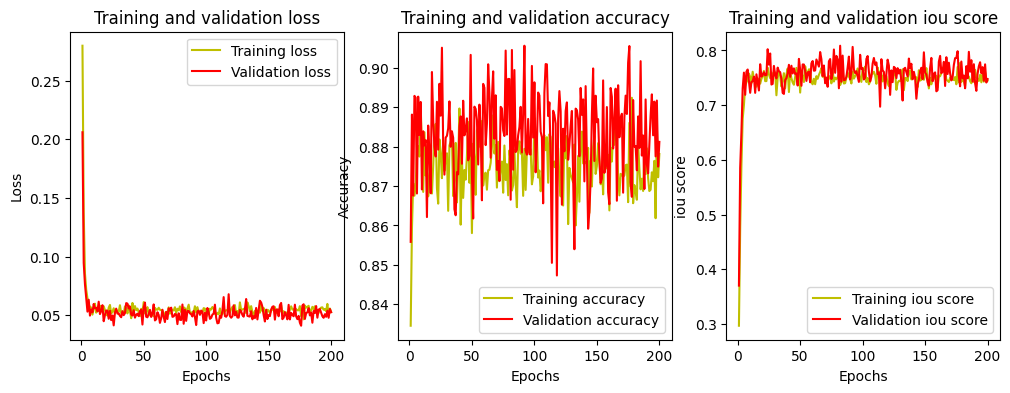

In [40]:
# Plot Training History
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    iou_score = history.history['iou_score']
    val_iou_score = history.history['val_iou_score']
    epochs = range(1, len(val_iou_score) + 1)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(epochs, accuracy, 'y', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, iou_score, 'y', label='Training iou score')
    plt.plot(epochs, val_iou_score, 'r', label='Validation iou score')
    plt.title('Training and validation iou score')
    plt.xlabel('Epochs')
    plt.ylabel('iou score')
    plt.legend()
    
    plt.show()

plot_training_history(history)

In [41]:
import gc
gc.collect()

15160

In [42]:
test_img_input=np.expand_dims(test_img, 0)
print(test_img.shape)
print(test_img_input.shape)
test_pred1 = model.predict(test_img_input)
test_prediction1 = np.squeeze(test_pred1, axis=0)
print(test_pred1.shape)
print(test_prediction1.shape)


(64, 64, 64, 3)
(1, 64, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
(1, 64, 64, 64, 1)
(64, 64, 64, 1)


In [43]:
ground_truth_argmax = np.argmax(ground_truth, axis=3)
test_prediction_argmax = np.argmax(test_prediction1, axis=3)
print(ground_truth.shape)
print(ground_truth_argmax.shape)
print(test_prediction1.shape)
print(test_img.shape)
print(test_prediction_argmax.shape)

(64, 64, 64, 1)
(64, 64, 64)
(64, 64, 64, 1)
(64, 64, 64, 3)
(64, 64, 64)


In [44]:
np.unique(test_prediction1)

array([5.0987377e-17, 5.9331468e-17, 1.3586653e-16, ..., 9.9451113e-01,
       9.9538058e-01, 9.9666363e-01], dtype=float32)

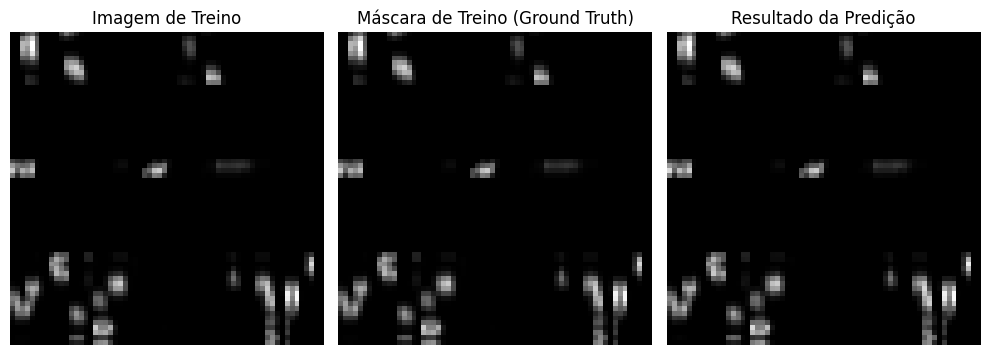

In [45]:

slice_index =32
# Plotar o slice escolhido
plt.figure(figsize=(10, 5))

# Original (Imagem de Teste)
plt.subplot(1, 3, 1)
plt.imshow(test_img[slice_index, :, :, 0], cmap='gray')
plt.title('Imagem de Treino')
plt.axis('off')

# Ground Truth (Máscara de Teste)
plt.subplot(1, 3, 2)
plt.imshow(ground_truth[slice_index, :, :], cmap='gray')
plt.title('Máscara de Treino (Ground Truth)')
plt.axis('off')

# Predição (Resultado da Predição)
plt.subplot(1, 3, 3)
plt.imshow(test_prediction1[slice_index,:, :], cmap='gray')
plt.title('Resultado da Predição')
plt.axis('off')

plt.tight_layout()
plt.show()

In [46]:
# Limpar a sessão do TensorFlow (parcialmente) e coletar lixo
tf.keras.backend.clear_session()
gc.collect()


0

In [47]:
del model
gc.collect()

0